In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TVF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from network import Modele
from tqdm import tqdm
from utils import class_weights

%load_ext autoreload

%autoreload 2

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
#Simple Dataset class for our change detection dataset

class ChangeDetectionDataset(Dataset):
    def __init__(self, csv_file="data.csv", data_dir="./data", batch_size=1, transform=None, crop_size=128):
        #repeat the data 5 times to have more data
        self.data = pd.read_csv(csv_file).sample(frac=20, replace=True)
        self.data_dir = data_dir
        self.transform = transform
        self.batch_size = batch_size
        self.crop_size = crop_size
    def __len__(self):
        return len(self.data)

    def random_crop(self, img1, img2, cm, size):
        x = np.random.randint(0, img1.shape[2]-size)
        y = np.random.randint(0, img1.shape[1]-size)
        img1 = img1[:,y:y+size, x:x+size]
        img2 = img2[:,y:y+size, x:x+size]
        cm = cm[0:1, y:y+size, x:x+size]
        return img1, img2, cm

    def random_flip(self, img1,img2,cm, chance=0.5):
        if (np.random.randint(0,1)> chance):
            img1 = TVF.hflip(img1)
            img2 = TVF.hflip(img2)
            cm = TVF.hflip(cm)

        if (np.random.randint(0,1)> chance):
            img1 = TVF.vflip(img1)
            img2 = TVF.vflip(img2)
            cm = TVF.vflip(cm)

        return img1, img2, cm

    def __getitem__(self, idx):
        img1 = read_image(self.data_dir+'/'+self.data.iloc[idx,0])
        img2 = read_image(self.data_dir+'/'+self.data.iloc[idx,1])
        cm = read_image(self.data_dir+'/'+self.data.iloc[idx,2])

        img1Tensor = torch.zeros((3, self.crop_size, self.crop_size), dtype=torch.float32)
        img2Tensor = torch.zeros((3, self.crop_size, self.crop_size), dtype=torch.float32)
        cmTensor = torch.zeros((1, self.crop_size, self.crop_size), dtype=torch.float32)
        
        crop1, crop2, cropcm = self.random_crop(img1[:,:,:], img2[:,:,:], cm[:,:,:], self.crop_size)
        crop1, crop2, cropcm = self.random_flip(crop1[:,:,:], crop2[:,:,:], cropcm[:,:,:])
        img1Tensor[:,:,:] = crop1.float()/255
        img2Tensor[:,:,:] = crop2.float()/255
        cmTensor[:,:,:] = cropcm.float()/255
        #apply the same transformation to all images as batch dimension
        return img1Tensor, img2Tensor, cmTensor
        

In [4]:
#Simple DataLoader class for our change detection dataset
batch_size = 32

weights = torch.Tensor(class_weights("data.csv")).to(device)

train_dataset= ChangeDetectionDataset(data_dir="data",csv_file="train.csv", batch_size=batch_size, transform=None)
val_dataset = ChangeDetectionDataset(data_dir="data",csv_file="val.csv", batch_size=1, transform=None)
train_loader = DataLoader(batch_size=batch_size, dataset=train_dataset, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, shuffle=True)
#Simple function to display a batch of images

def show_batch(batch):
    img1s, img2s, cms = batch

    for i in range(len(img1s)):
        img1 = img1s[i,:,:,:]
        img2 = img2s[i,:,:,:]
        cm = cms[i,:,:,:]
        fig, ax = plt.subplots(1,3)
        ax[0].imshow(img1.permute(1,2,0))
        ax[1].imshow(img2.permute(1,2,0))
        ax[2].imshow(cm.permute(1,2,0), cmap='gray')
        plt.show()

#a = next(iter(train_loader))
#show_batch(a)

In [ ]:
n_epoch = 50
learning_rate = 0.001
model = Modele()
loss_fn = nn.NLLLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss, val_loss = [], []
model = model.to(device)
best_loss =1000

for epoch in range(n_epoch):
    model.train()
    accu = 0
    for img1,img2,cm in tqdm(train_loader, ascii=" >="):
        img1,img2,cm = img1.to(device),img2.to(device),cm.to(device)
        #Forward pass
        y_pred = model(img1, img2)
        cm = cm.squeeze(1).long()
        loss = loss_fn(y_pred, cm)
        accu += loss
        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(accu/len(train_loader))

    model.eval()
    accu=0
    with torch.no_grad():
        for img1,img2,cm in val_loader:
            img1,img2,cm = img1.to(device),img2.to(device),cm.to(device)
            y_pred=model(img1,img2)
            #y_pred, cm = torch.flatten(y_pred, start_dim=1), torch.flatten(cm, start_dim=1)
            cm = cm.squeeze(1).long()
            loss = loss_fn(y_pred,cm)
            accu += loss
            if(accu/len(val_loader) < best_loss):
                best_loss = accu/len(val_loader)
                torch.save(model.state_dict(), "best_model.pt")
        val_loss.append(accu/len(val_loader))
    print(f"Train {epoch+1}: {train_loss[-1]} and Valid {epoch+1}: {val_loss[-1]}")
    

  0%|          | 0/12 [00:00<?, ?it/s]c:\Python312\Lib\site-packages\torch\nn\modules\conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv2d(input, weight, bias, self.stride,
100%|==========| 12/12 [00:15<00:00,  1.27s/it]


Train 1: 0.4642261266708374 and Valid 1: 0.8025559186935425


100%|==========| 12/12 [00:14<00:00,  1.24s/it]


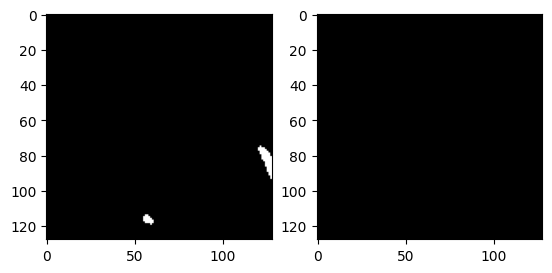

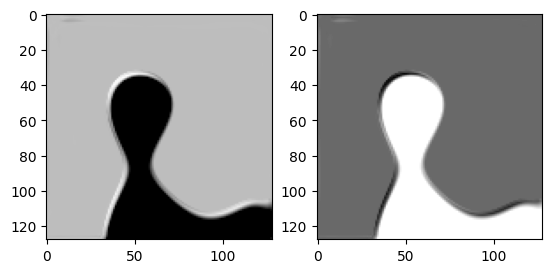

In [ ]:
model.cpu()

im1,im2,cm = next(iter(val_loader))
cm_pred = model(im1,im2, with_attn=False)
_,cm_pred1 = torch.max(cm_pred, dim=1)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(cm[0].permute(1,2,0), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(cm_pred1.detach()[0], cmap='gray')
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.imshow(cm_pred[0][0].detach(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(cm_pred[0][1].detach(), cmap='gray')
